In [1]:
import root_pandas as rp
import uproot

Welcome to JupyROOT 6.18/04


### uproot vs. root_pandas diffs

In [36]:
outpath_rp = '/nfs/dust/cms/user/filatovo/HTT/CMSSW_10_2_16/src/mlFramework/outputs/predictions_2017_rp/'
outpath_uproot = '/nfs/dust/cms/user/filatovo/HTT/CMSSW_10_2_16/src/mlFramework/outputs/predictions_2017_uproot/'

In [37]:
# ST_predict_up = rp.read_root(outpath + '/mt-NOMINAL_ntuple_ST.root', key='TauCheck_CMS_scale_j_JES13TeVUp')
# ST_predict_down = rp.read_root(outpath + '/mt-NOMINAL_ntuple_ST.root', key='TauCheck_CMS_scale_j_JES13TeVDown')
# ST_predict_center = rp.read_root(outpath + '/mt-NOMINAL_ntuple_ST.root', key='TauCheck')

In [38]:
ST_uproot_file = uproot.open(outpath_uproot + '/mt-NOMINAL_ntuple_ST.root')['TauCheck']
ST_uproot = ST_uproot_file.pandas.df()

ST = rp.read_root(outpath_rp + '/mt-NOMINAL_ntuple_ST.root', key='TauCheck')

In [39]:
ST.shape, ST_uproot.shape

((57842, 409), (57842, 410))

In [40]:
set(ST_uproot.columns.values) - set(ST.columns.values)

{'__index__'}

In [41]:
np.mean(ST.predicted_prob.values), np.mean(ST_uproot.predicted_prob.values)

(0.5914628256048834, 0.5914628256048834)

In [42]:
ST.predicted_prob[:5] - ST_uproot.predicted_prob[:5]

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: predicted_prob, dtype: float64

In [43]:
ST.pt_2[:5] - ST_uproot.pt_2[:5]

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: pt_2, dtype: float32

In [44]:
ST_uproot.jpt_2

entry
0        -10.000000
1        -10.000000
2         42.047237
3        -10.000000
4        -10.000000
            ...    
57837    215.550125
57838    -10.000000
57839     74.075287
57840     44.566254
57841     74.735481
Name: jpt_2, Length: 57842, dtype: float64

In [45]:
ST.head()

,jdeta,eta_1,m_sv,iso_1,nbtag,bpt_1,mjj,gen_sm_htt125,gen_ps_htt125,gen_mm_htt125,...,puppimet,byIsolationMVA3newDMwLTraw_2,puCorrPtSum_1,jcsv_2,event_weight,target,train_weight,THU,predicted_class,predicted_prob
0,-10.000000,-1.080279,165.405075,0.011258,0,-10.000000,-10.000000,1.0,1.0,1.0,...,20.569374,2.396453e-38,-9999.0,0.056228,1.0,-1,1.0,1,3.0,0.382496
1,-10.000000,-1.068381,121.302795,0.000000,0,-10.000000,-10.000000,1.0,1.0,1.0,...,28.313576,2.396453e-38,-9999.0,-2.000000,1.0,-1,1.0,1,0.0,0.383253
2,1.254092,1.886886,127.518707,0.039022,1,60.101307,85.066223,1.0,1.0,1.0,...,34.682636,2.396453e-38,-9999.0,0.029805,1.0,-1,1.0,1,2.0,0.508685
3,-10.000000,1.195071,130.526566,0.072335,0,-10.000000,-10.000000,1.0,1.0,1.0,...,21.510664,2.396453e-38,-9999.0,0.078827,1.0,-1,1.0,1,3.0,0.407221
4,-10.000000,1.107226,88.424194,0.010200,0,-10.000000,-10.000000,1.0,1.0,1.0,...,23.609083,2.396453e-38,-9999.0,0.029449,1.0,-1,1.0,1,1.0,0.658826


### Reader

In [10]:
from Reader import Reader
import copy
import json
import sys
import os
import time
from glob import glob
import argparse
import _pickle as cPickle
import subprocess as sp
import multiprocessing as mp
from collections import deque

import numpy as np
import pandas as pd
import keras
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model as lm
import seaborn as sns
from matplotlib import pyplot as plt

from run_model import *
import root_pandas as rp
import uproot

Using TensorFlow backend.
/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/afs/desy.de/user/f/filatovo/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/afs/desy.de/user

In [11]:
channel = 'mt'
era = '2017'
samples = f'conf/global_config_{channel}_{era}.json'
use = 'keras'

# train = False
# short = True
# datacard = False
# add_nominal = Falsea


In [12]:
read = Reader(channel = channel, config_file = samples, folds=2, era = era)

In [13]:
target_names = read.config["target_names"]
variables = read.config["variables"]

models_folder = era + "/models"
if not os.path.exists(models_folder):
    os.makedirs(models_folder)

modelname = f'{models_folder}/{channel}.{use}'
scaler = None

In [14]:
trainSet = read.getSamplesForTraining()

Loading: TJ from mt-NOMINAL_ntuple_SingleTop.root, tree = TauCheck
size of TJ is 2661
Loading: TL from mt-NOMINAL_ntuple_SingleTop.root, tree = TauCheck
size of TL is 7475
Loading: TT from mt-NOMINAL_ntuple_SingleTop.root, tree = TauCheck
size of TT is 1069
Loading: TTJ from mt-NOMINAL_ntuple_TT.root, tree = TauCheck
size of TTJ is 50846
Loading: TTL from mt-NOMINAL_ntuple_TT.root, tree = TauCheck
size of TTL is 267199
Loading: TTT from mt-NOMINAL_ntuple_TT.root, tree = TauCheck
size of TTT is 33900
Loading: VVJ from mt-NOMINAL_ntuple_VV.root, tree = TauCheck
size of VVJ is 938
Loading: VVL from mt-NOMINAL_ntuple_VV.root, tree = TauCheck
size of VVL is 2773
Loading: VVT from mt-NOMINAL_ntuple_VV.root, tree = TauCheck
size of VVT is 1365
Loading: W from mt-NOMINAL_ntuple_WJets.root, tree = TauCheck
size of W is 13093
Loading: ZJ from mt-NOMINAL_ntuple_DY.root, tree = TauCheck
size of ZJ is 3225
Loading: ZL from mt-NOMINAL_ntuple_DY.root, tree = TauCheck
size of ZL is 11310
Loading: ZTT 

In [15]:
scaler = trainScaler(trainSet, variables )
with open("{0}/StandardScaler.{1}.pkl".format(models_folder,channel), 'wb') as FSO:
    pickle.dump(scaler, FSO , 2)
scaler = [scaler, scaler] # Hotfix since KIT uses 2 scalers
trainSet = applyScaler(scaler, trainSet, variables)

### Model

In [16]:
if use == 'keras':
    from KerasModel import KerasObject as modelObject
    parameters = "conf/parameters_keras.json"
if use == 'xgb':
    from XGBModel import XGBObject as modelObject
    parameters = "conf/parameters_xgb.json"

In [17]:
model_loaded = modelObject( parameter_file = parameters,
                             variables=variables,
                             target_names = target_names )

In [18]:
model_loaded.models = []
model_loaded.models.append( lm(modelname + "_10epochs.fold0") )
model_loaded.models.append( lm(modelname + "_10epochs.fold1") )


2020-01-15 20:27:11.129630: I tensorflow/core/platform/cpu_feature_guard.cc:140] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA


In [21]:
read.for_prediction = True
read.setFullSamples(True)

In [25]:
data_cfg = read.itersamples[1]
data_sample = read.loadForMe(data_cfg)

folds = []
for sample in data_sample:
    read.modifyDF(sample, data_cfg)
    folds.append([sample.query( "abs(evt % 2) != 0 " ).reset_index(drop=True), sample.query( "abs(evt % 2) == 0 " ).reset_index(drop=True) ])

Loading: DY_full from mt-NOMINAL_ntuple_DY.root, tree = TauCheck_CMS_scale_j_JES13TeVUp


In [26]:
len(folds)

4

In [29]:
fold_prediction = model_loaded.predict( applyScaler(scaler, folds[0], variables) )

In [30]:
fold0_prediction = fold_prediction[0].predicted_prob
fold1_prediction = fold_prediction[1].predicted_prob

In [31]:
fold0_prediction.mean(), fold1_prediction.mean()

(0.5444495574496626, 0.5402303859131747)

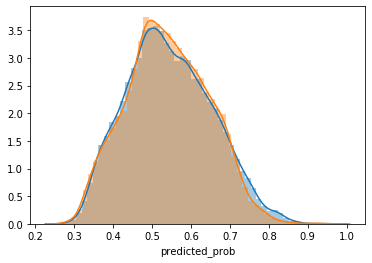

In [32]:
sns.distplot(fold0_prediction)
sns.distplot(fold1_prediction)